# Bagging

This notebook introduces a very natural strategy to build ensembles of
machine learning models named "bagging".

"Bagging" stands for Bootstrap AGGregatING. It uses bootstrap resampling
(random sampling with replacement) to learn several models on random
variations of the training set. At predict time, the predictions of each
learner are aggregated to give the final predictions.

First, we will generate a simple synthetic dataset to get insights regarding
bootstraping.

In [1]:
import pandas as pd
import numpy as np

# create a random number generator that will be used to set the randomness
rng = np.random.RandomState(1)


def generate_data(n_samples=30):
    """Generate synthetic dataset. Returns `data_train`, `data_test`,
    `target_train`."""
    x_min, x_max = -3, 3
    x = rng.uniform(x_min, x_max, size=n_samples)
    noise = 4.0 * rng.randn(n_samples)
    y = x ** 3 - 0.5 * (x + 1) ** 2 + noise
    y /= y.std()

    data_train = pd.DataFrame(x, columns=["Feature"])
    data_test = pd.DataFrame(
        np.linspace(x_max, x_min, num=300), columns=["Feature"])
    target_train = pd.Series(y, name="Target")

    return data_train, data_test, target_train

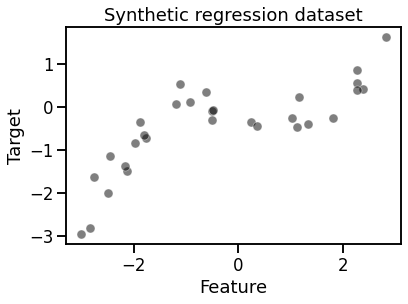

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

data_train, data_test, target_train = generate_data(n_samples=30)
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
_ = plt.title("Synthetic regression dataset")


The relationship between our feature and the target to predict is non-linear.
However, a decision tree is capable of approximating such a non-linear
dependency:

In [3]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(data_train, target_train)
y_pred = tree.predict(data_test)

Remember that the term "test" here refers to data that was not used for
training and computing an evaluation metric on such a synthetic test set
would be meaningless.

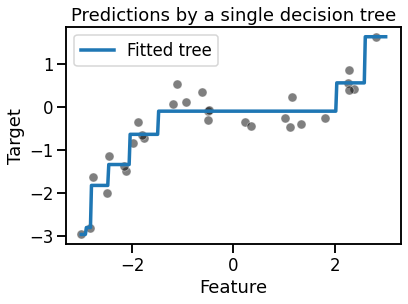

In [4]:
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
plt.plot(data_test["Feature"], y_pred, label="Fitted tree")
plt.legend()
_ = plt.title("Predictions by a single decision tree")

Let's see how we can use bootstraping to learn several trees.

## Bootstrap resampling

A bootstrap sample corresponds to a resampling with replacement, of the
original dataset, a sample that is the same size as the original dataset.
Thus, the bootstrap sample will contain some data points several times while
some of the original data points will not be present.

We will create a function that given `data` and `target` will return a
resampled variation `data_bootstrap` and `target_bootstrap`.

In [5]:
def bootstrap_sample(data, target):
    # Indices corresponding to a sampling with replacement of the same sample
    # size than the original data
    bootstrap_indices = rng.choice(
        np.arange(target.shape[0]), size=target.shape[0], replace=True,
    )
    # In pandas, we need to use `.iloc` to extract rows using an integer
    # position index:
    data_bootstrap = data.iloc[bootstrap_indices]
    target_bootstrap = target.iloc[bootstrap_indices]
    return data_bootstrap, target_bootstrap


We will generate 3 bootstrap samples and qualitatively check the difference
with the original dataset.

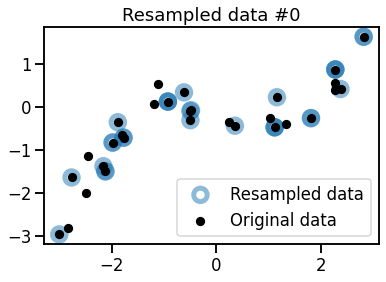

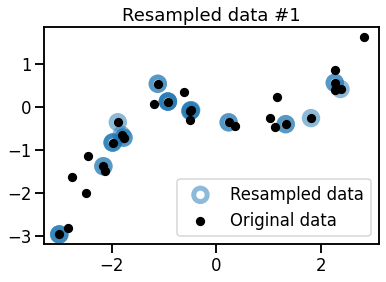

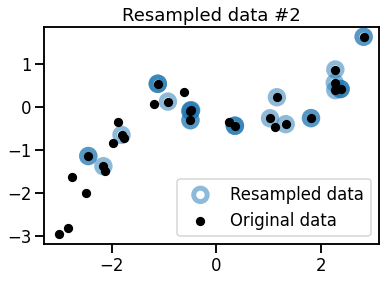

In [6]:
n_bootstraps = 3
for bootstrap_idx in range(n_bootstraps):
    # draw a bootstrap from the original data
    data_bootstrap, target_bootstrap = bootstrap_sample(
        data_train, target_train,
    )
    plt.figure()
    plt.scatter(data_bootstrap["Feature"], target_bootstrap,
                color="tab:blue", facecolors="none",
                alpha=0.5, label="Resampled data", s=180, linewidth=5)
    plt.scatter(data_train["Feature"], target_train,
                color="black", s=60,
                alpha=1, label="Original data")
    plt.title(f"Resampled data #{bootstrap_idx}")
    plt.legend()


Observe that the 3 variations all share common points with the original
dataset. Some of the points are randomly resampled several times and appear
as darker blue circles.

The 3 generated bootstrap samples are all different from the original dataset
and from each other. To confirm this intuition, we can check the number of
unique samples in the bootstrap samples.

In [7]:
data_train_huge, data_test_huge, target_train_huge = generate_data(
    n_samples=100_000)
data_bootstrap_sample, target_bootstrap_sample = bootstrap_sample(
    data_train_huge, target_train_huge)

ratio_unique_sample = (np.unique(data_bootstrap_sample).size /
                       data_bootstrap_sample.size)
print(
    f"Percentage of samples present in the original dataset: "
    f"{ratio_unique_sample * 100:.1f}%"
)

Percentage of samples present in the original dataset: 63.2%



On average, ~63.2% of the original data points of the original dataset will
be present in a given bootstrap sample. The other ~36.8% are repeated
samples.

We are able to generate many datasets, all slightly different.

Now, we can fit a decision tree for each of these datasets and they all shall
be slightly different as well.

In [8]:
bag_of_trees = []
for bootstrap_idx in range(n_bootstraps):
    tree = DecisionTreeRegressor(max_depth=3, random_state=0)

    data_bootstrap_sample, target_bootstrap_sample = bootstrap_sample(
        data_train, target_train)
    tree.fit(data_bootstrap_sample, target_bootstrap_sample)
    bag_of_trees.append(tree)


Now that we created a bag of different trees, we can use each of the trees to
predict the samples within the range of data. They shall give slightly
different predictions.

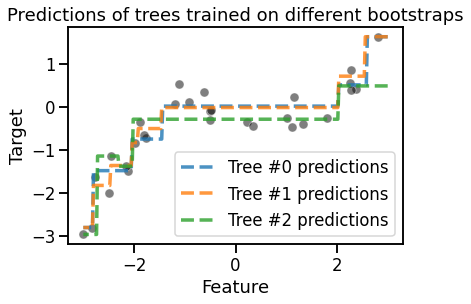

In [9]:
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
for tree_idx, tree in enumerate(bag_of_trees):
    tree_predictions = tree.predict(data_test)
    plt.plot(data_test["Feature"], tree_predictions, linestyle="--", alpha=0.8,
             label=f"Tree #{tree_idx} predictions")

plt.legend()
_ = plt.title("Predictions of trees trained on different bootstraps")

## Aggregating

Once our trees are fitted, we are able to get predictions for each of
them. In regression, the most straightforward way to combine those
predictions is just to average them: for a given test data point, we feed the
input feature values to each of the `n` trained models in the ensemble and as
a result compute `n` predicted values for the target variable. The final
prediction of the ensemble for the test data point is the average of those
`n` values.

We can plot the averaged predictions from the previous example.

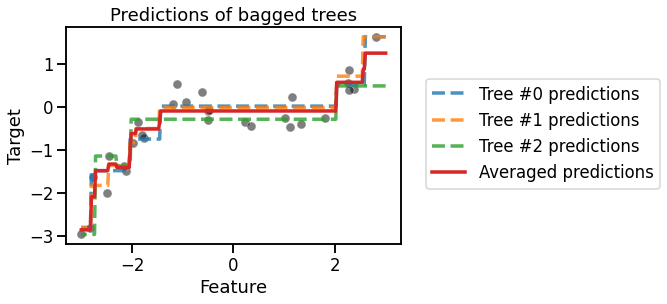

In [10]:
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)

bag_predictions = []
for tree_idx, tree in enumerate(bag_of_trees):
    tree_predictions = tree.predict(data_test)
    plt.plot(data_test["Feature"], tree_predictions, linestyle="--", alpha=0.8,
             label=f"Tree #{tree_idx} predictions")
    bag_predictions.append(tree_predictions)

bag_predictions = np.mean(bag_predictions, axis=0)
plt.plot(data_test["Feature"], bag_predictions, label="Averaged predictions",
         linestyle="-")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Predictions of bagged trees")


The unbroken red line shows the averaged predictions, which would be the
final predictions given by our 'bag' of decision tree regressors. Note that
the predictions of the ensemble is more stable because of the averaging
operation. As a result, the bag of trees as a whole is less likely to overfit
than the individual trees.

## Bagging in scikit-learn

Scikit-learn implements the bagging procedure as a "meta-estimator", that is
an estimator that wraps another estimator: it takes a base model that is
cloned several times and trained independently on each bootstrap sample.

The following code snippet shows how to build a bagging ensemble of decision
trees. We set `n_estimators=100` instead of 3 in our manual implementation
above to get a stronger smoothing effect.

In [14]:
from sklearn.ensemble import BaggingRegressor

bagged_trees = BaggingRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=3),
    n_estimators=100,
)
_ = bagged_trees.fit(data_train, target_train)


Let us visualize the predictions of the ensemble on the same interval of data:

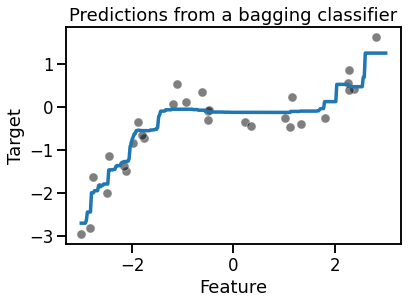

In [15]:
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)

bagged_trees_predictions = bagged_trees.predict(data_test)
plt.plot(data_test["Feature"], bagged_trees_predictions)

_ = plt.title("Predictions from a bagging classifier")


Because we use 100 trees in the ensemble, the average prediction is indeed
slightly smoother but very similar to our previous average plot.

It is possible to access the internal models of the ensemble stored as a
Python list in the `bagged_trees.estimators_` attribute after fitting.

Let us compare the based model predictions with their average:

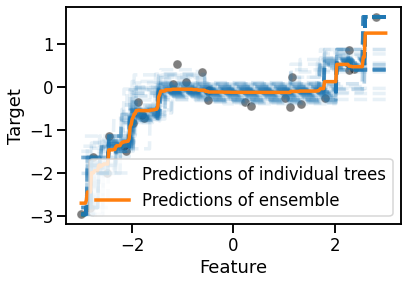

In [18]:
for tree_idx, tree in enumerate(bagged_trees.estimators_):
    label = "Predictions of individual trees" if tree_idx == 0 else None
    # we convert `data_test` into a NumPy array to avoid a warning raised in scikit-learn
    tree_predictions = tree.predict(data_test.to_numpy())
    plt.plot(data_test["Feature"], tree_predictions, linestyle="--", alpha=0.1,
             color="tab:blue", label=label)

sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)

bagged_trees_predictions = bagged_trees.predict(data_test)
plt.plot(data_test["Feature"], bagged_trees_predictions,
         color="tab:orange", label="Predictions of ensemble")
_ = plt.legend()


We used a low value of the opacity parameter `alpha` to better appreciate the
overlap in the prediction functions of the individual trees.

This visualization gives some insights on the uncertainty in the predictions
in different areas of the feature space.

## Bagging complex pipelines

While we used a decision tree as a base model, nothing prevents us of using
any other type of model.

As we know that the original data generating function is a noisy polynomial
transformation of the input variable, let us try to fit a bagged polynomial
regression pipeline on this dataset:

In [19]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline


polynomial_regressor = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=4),
    Ridge(alpha=1e-10),
)


This pipeline first scales the data to the 0-1 range with `MinMaxScaler`.
Then it extracts degree-4 polynomial features. The resulting features will
all stay in the 0-1 range by construction: if `x` lies in the 0-1 range then
`x ** n` also lies in the 0-1 range for any value of `n`.

Then the pipeline feeds the resulting non-linear features to a regularized
linear regression model for the final prediction of the target variable.

Note that we intentionally use a small value for the regularization parameter
`alpha` as we expect the bagging ensemble to work well with slightly overfit
base models.

The ensemble itself is simply built by passing the resulting pipeline as the
`base_estimator` parameter of the `BaggingRegressor` class:

In [20]:
bagging = BaggingRegressor(
    base_estimator=polynomial_regressor,
    n_estimators=100,
    random_state=0,
)
_ = bagging.fit(data_train, target_train)

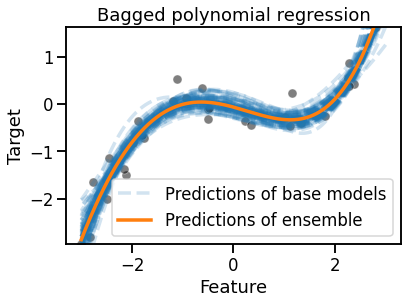

In [21]:
for i, regressor in enumerate(bagging.estimators_):
    # we convert `data_test` into a NumPy array to avoid a warning raised in scikit-learn
    regressor_predictions = regressor.predict(data_test.to_numpy())
    base_model_line = plt.plot(
        data_test["Feature"], regressor_predictions, linestyle="--", alpha=0.2,
        label="Predictions of base models" if i == 0 else None,
        color="tab:blue"
    )

sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
bagging_predictions = bagging.predict(data_test)
plt.plot(data_test["Feature"], bagging_predictions,
         color="tab:orange", label="Predictions of ensemble")
plt.ylim(target_train.min(), target_train.max())
plt.legend()
_ = plt.title("Bagged polynomial regression")


The predictions of this bagged polynomial regression model looks
qualitatively better than the bagged trees. This is somewhat expected since
the base model better reflects our knowledge of the true data generating
process.

Again the different shades induced by the overlapping blue lines let us
appreciate the uncertainty in the prediction of the bagged ensemble.

To conclude this notebook, we note that the bootstrapping procedure is a
generic tool of statistics and is not limited to build ensemble of machine
learning models. The interested reader can learn more on the [Wikipedia
article on
bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)).